In [1]:
# ------------------------
## ----import libraries
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import Colormap
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmocean as ccm
import pandas as pd
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox


In [2]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38529 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38529/status,
Dashboard: http://127.0.0.1:38529/status,Workers: 3
Total threads: 6,Total memory: 12.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34489,Workers: 3
Dashboard: http://127.0.0.1:38529/status,Total threads: 6
Started: Just now,Total memory: 12.00 GiB
Comm: tcp://127.0.0.1:35483,Total threads: 2
Dashboard: http://127.0.0.1:43383/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:44521,


In [3]:
# read grid files
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh = xr.open_dataset(diri+'mesh_hgr.nc',chunks = {"x":360,"y":500}) # {"x":500,"y":500} 
tmask = mesh.tmask[0,0,:,:] # grille lat/lon
nav_lon = mesh.nav_lon.squeeze()
nav_lat = mesh.nav_lat.squeeze()
e1t = mesh.e1t.squeeze()
e2t = mesh.e2t.squeeze()
cellAreav0=e1t*e2t

In [4]:
Chukchi_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/chukchi_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
eastsiberian_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/eastSiberian_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
laptev_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/laptev_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
kara_part1_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/kara_part1_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
kara_part2_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/kara_part2_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
kara_mask = kara_part1_mask + kara_part2_mask
barents_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/barents_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
norwegian_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/norwegian_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
BaffinHudson_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/BaffinHudson_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
caa_part1 = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/caa_part1.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
caa_part2 = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/caapart2_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()
caa_mask = caa_part1 +caa_part2
beaufort_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/beaufort_mask.nc',chunks = {"x":360,"y":500}).polymask.squeeze()

tot_mask = Chukchi_mask + eastsiberian_mask + laptev_mask + kara_mask + barents_mask + norwegian_mask + BaffinHudson_mask + caa_mask + beaufort_mask

In [5]:
# tot_mask.plot()

# Rivers runoff for GAI : interannual

## isolating the rivers of interest: Artic Rivers and saving them !

In [6]:
%%time
path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I"
chunk_size = {"time_counter":366,"x":360,"y":500} # {"x":500,"y":500} 
ds = xr.open_mfdataset(path+"/eORCA025_runoff_ISBA_noAA_noGR_y*.nc", chunks=chunk_size).sel(time_counter=slice('1980','2018'))
rnf = ds.sorunoff
# rnf_mask = ds.socoefr[0].where(ds.socoefr[0]==0.5)

CPU times: user 769 ms, sys: 279 ms, total: 1.05 s
Wall time: 8.51 s


In [11]:
%%time
rnf_chukchi = rnf.where(Chukchi_mask,drop=True)
cellArea = cellAreav0.where(Chukchi_mask,drop=True)
debit_chukchi = (rnf_chukchi * cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_chukchi = (debit_chukchi/1e3).compute()

rnf_eastsiberian = rnf.where(eastsiberian_mask,drop=True)
cellArea = cellAreav0.where(eastsiberian_mask,drop=True)
debit_eastsiberian = (rnf_eastsiberian *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_eastsiberian = (debit_eastsiberian/1e3).compute()

rnf_laptev = rnf.where(laptev_mask,drop=True)
cellArea = cellAreav0.where(laptev_mask,drop=True)
debit_laptev = (rnf_laptev *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_laptev = (debit_laptev/1e3).compute()

rnf_kara = rnf.where(kara_mask,drop=True)
cellArea = cellAreav0.where(kara_mask,drop=True)
debit_kara = (rnf_kara *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_kara = (debit_kara/1e3).compute()

rnf_barents = rnf.where(barents_mask,drop=True)
cellArea = cellAreav0.where(barents_mask,drop=True)
debit_barents = (rnf_barents *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_barents = (debit_barents/1e3).compute()

rnf_norwegian = rnf.where(norwegian_mask,drop=True)
cellArea = cellAreav0.where(norwegian_mask,drop=True)
debit_norwegian = (rnf_norwegian *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_norwegian = (debit_norwegian/1e3).compute()

rnf_BaffinHudson = rnf.where(BaffinHudson_mask,drop=True)
cellArea = cellAreav0.where(BaffinHudson_mask,drop=True)
debit_BaffinHudson = (rnf_BaffinHudson * cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_BaffinHudson = (debit_BaffinHudson/1e3).compute()

rnf_caa = rnf.where(caa_mask,drop=True)
cellArea = cellAreav0.where(caa_mask,drop=True)
debit_caa = (rnf_caa *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_caa = (debit_caa/1e3).compute()

rnf_beaufort = rnf.where(beaufort_mask,drop=True)
cellArea = cellAreav0.where(beaufort_mask,drop=True)
debit_beaufort = (rnf_beaufort *  cellArea / 1000).sum(('x','y')).groupby('time_counter.year').mean('time_counter')
debit_beaufort = (debit_beaufort/1e3).compute()


CPU times: user 40.2 s, sys: 2.89 s, total: 43.1 s
Wall time: 4min 11s


## vérification qu'on a bien tout pris dans la décomposition en bassin

In [12]:
debit_tot_bis = debit_chukchi +debit_eastsiberian +debit_laptev+debit_kara+debit_barents+debit_norwegian+debit_BaffinHudson +debit_caa +debit_beaufort

CPU times: user 19.9 ms, sys: 2.99 ms, total: 22.9 ms
Wall time: 20.5 ms


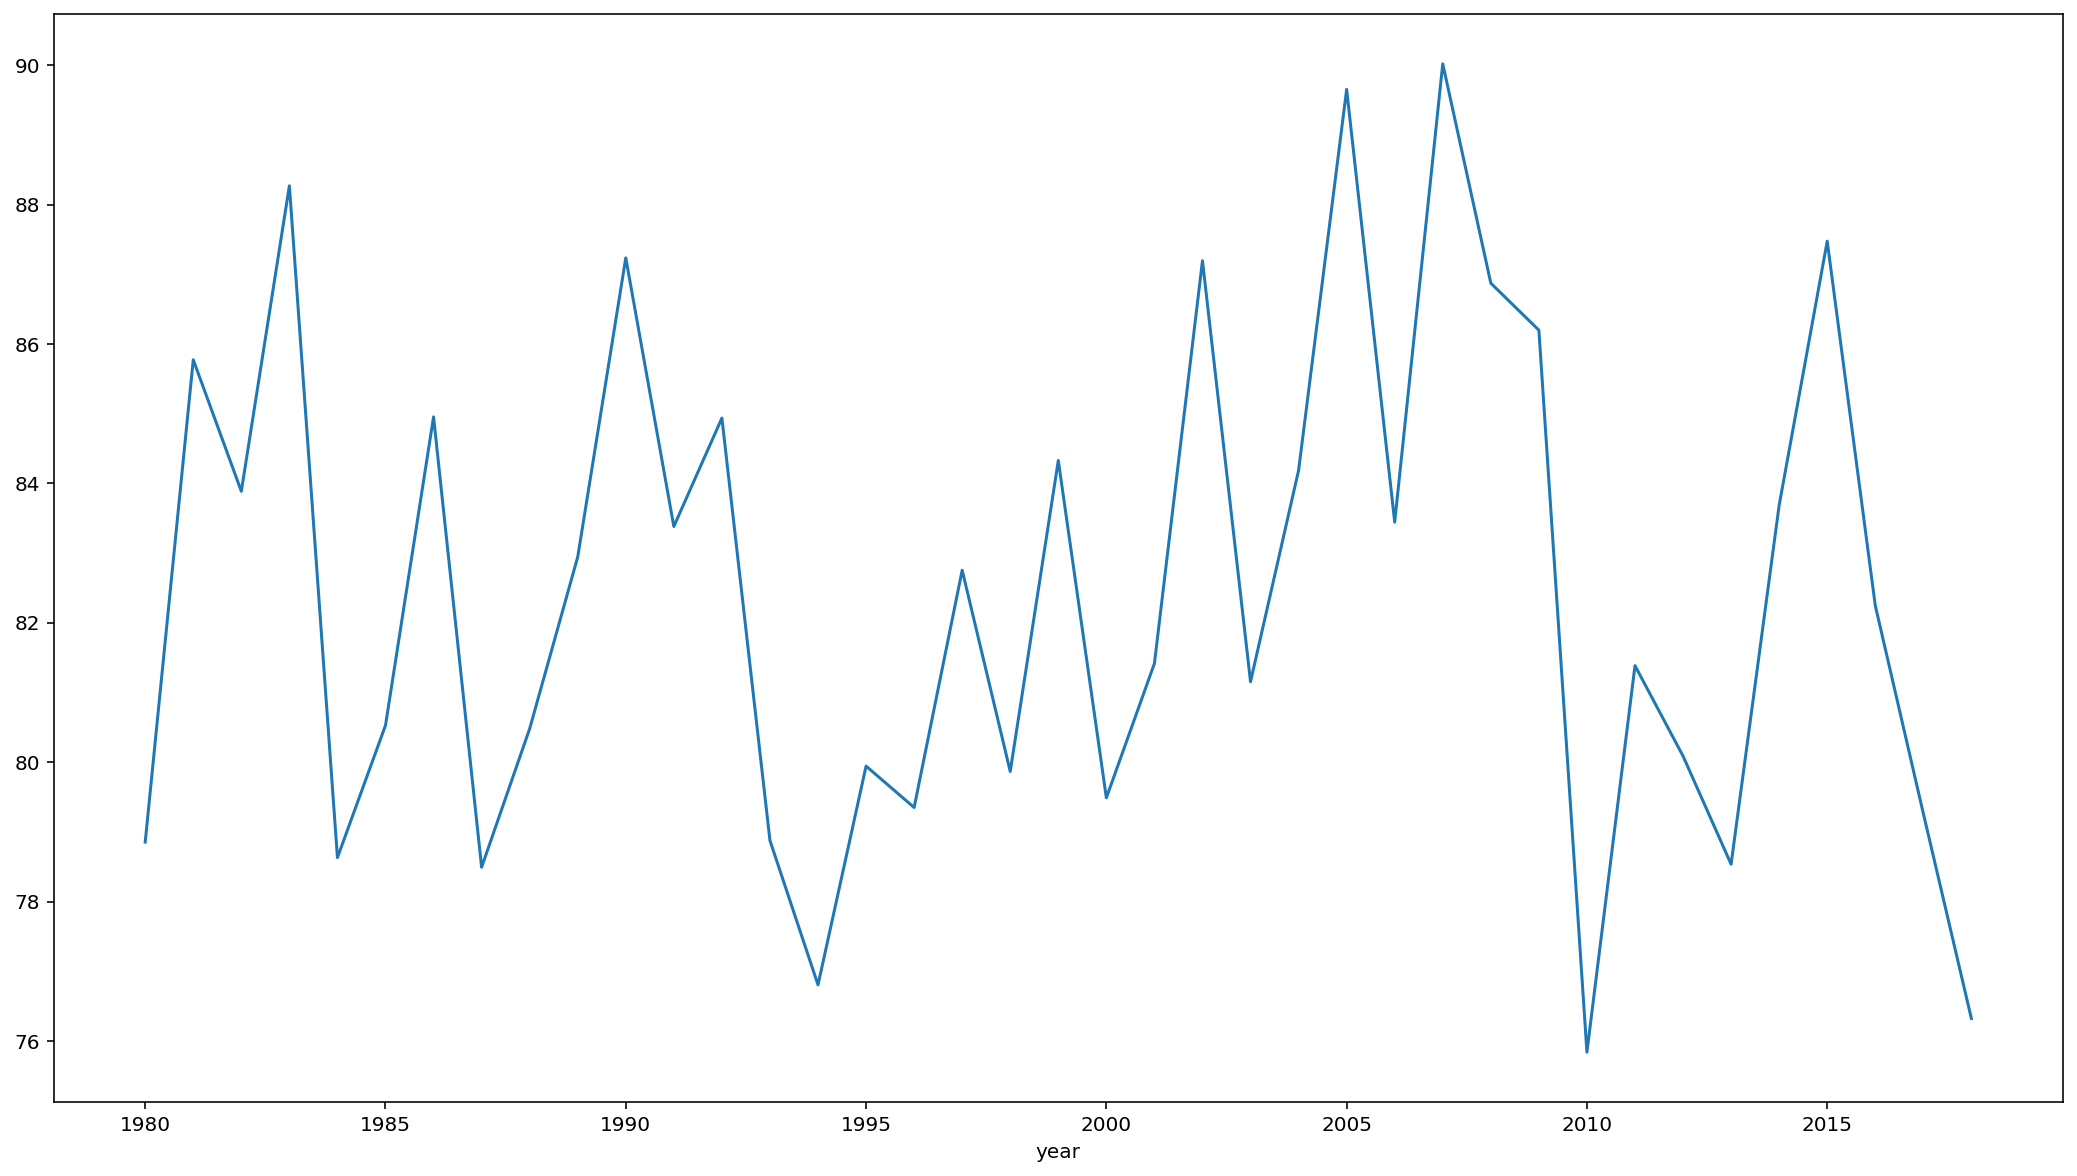

In [13]:
%%time
fig = plt.figure(figsize=([18,10]),facecolor='none', dpi=72*2)
debit_tot_bis.plot()

In [14]:
diroww = '/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/'
ds = xr.Dataset(
    data_vars=dict(chukchi=(["time_counter"], debit_chukchi.data),
                   eastsiberian=(["time_counter"], debit_eastsiberian.data),
                   laptev=(["time_counter"], debit_laptev.data),
                   kara=(["time_counter"], debit_kara.data),
                   barents=(["time_counter"], debit_barents.data),
                   norwegian=(["time_counter"], debit_norwegian.data),
                   baffinHudson=(["time_counter"], debit_BaffinHudson.data),
                   caa=(["time_counter"], debit_caa.data),
                   beaufort=(["time_counter"], debit_beaufort.data),

    ),

    coords=dict(time_counter=debit_beaufort.year.values),
    attrs=dict(description="river's dischrage per sea/region for run GAI [Sv]"),

)

ds.to_netcdf(path=diroww+'rivers_mean_rnf_perbasin_GAI.nc')

## load saved data and plot the bar chart for runoff GAI

In [5]:
rnf_perbasin_GAI = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/rivers_mean_rnf_perbasin_GAI.nc')

plotdataGAI = pd.DataFrame({
    "Chukchi Sea":rnf_perbasin_GAI.chukchi.data,
    "East Siberian Sea":rnf_perbasin_GAI.eastsiberian.data,
    "Laptev Sea":rnf_perbasin_GAI.laptev.data,
    "Kara Sea":rnf_perbasin_GAI.kara.data,
    "Barents Sea":rnf_perbasin_GAI.barents.data,
    "Norwegian Sea":rnf_perbasin_GAI.norwegian.data,
    "Baffin Bay":rnf_perbasin_GAI.baffinHudson.data,
    "CAA":rnf_perbasin_GAI.caa.data,
    "Beaufort Sea":rnf_perbasin_GAI.beaufort.data},
    index=np.arange(1980,2019))

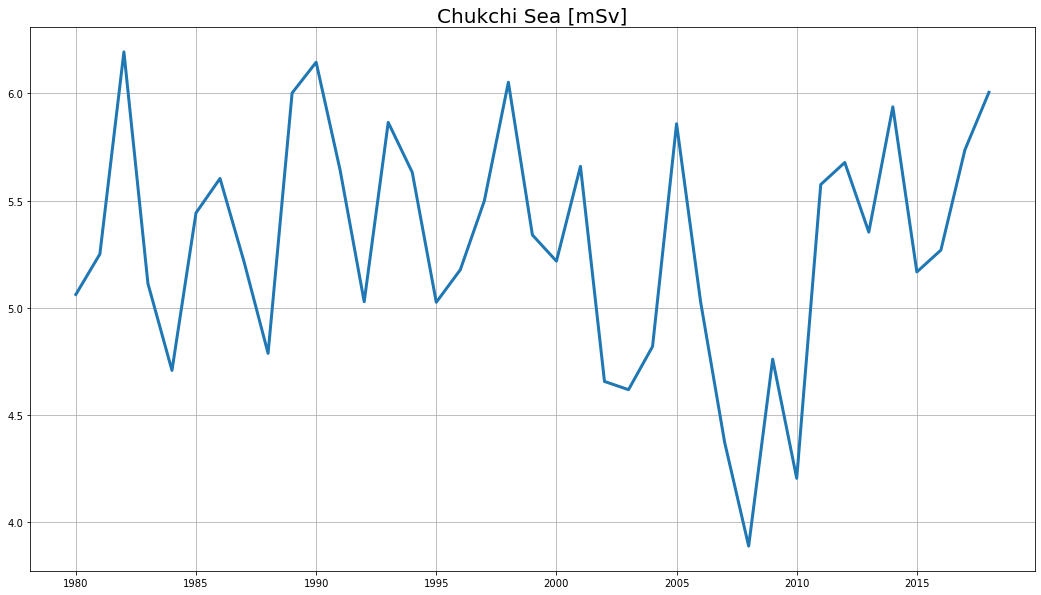

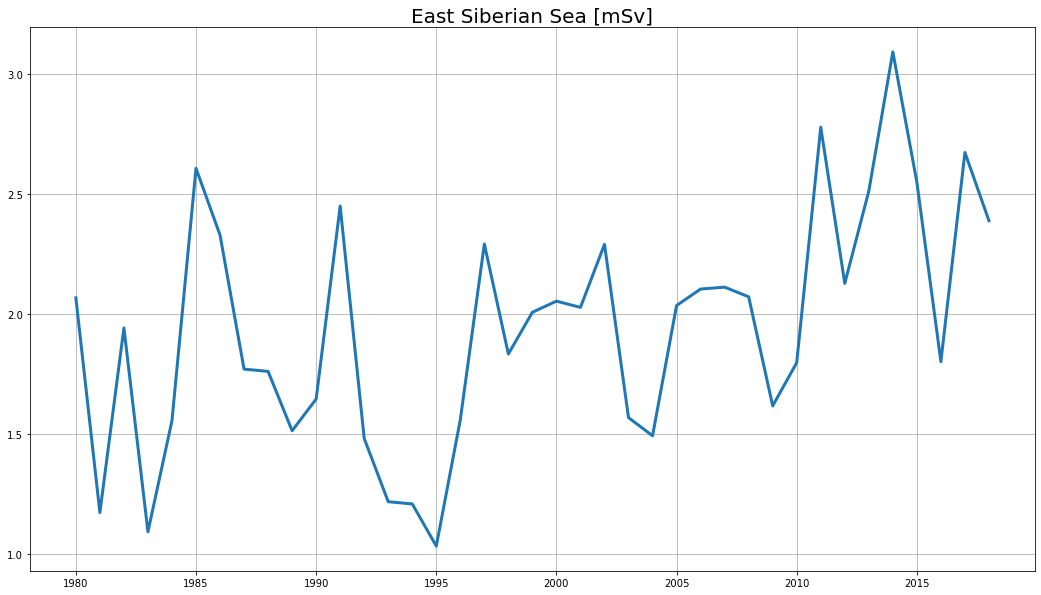

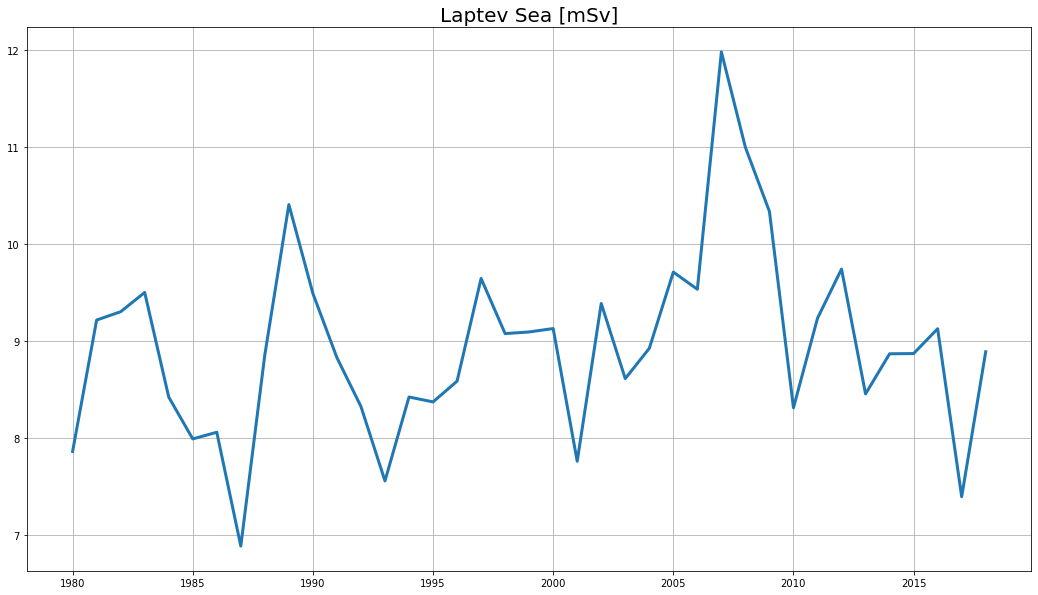

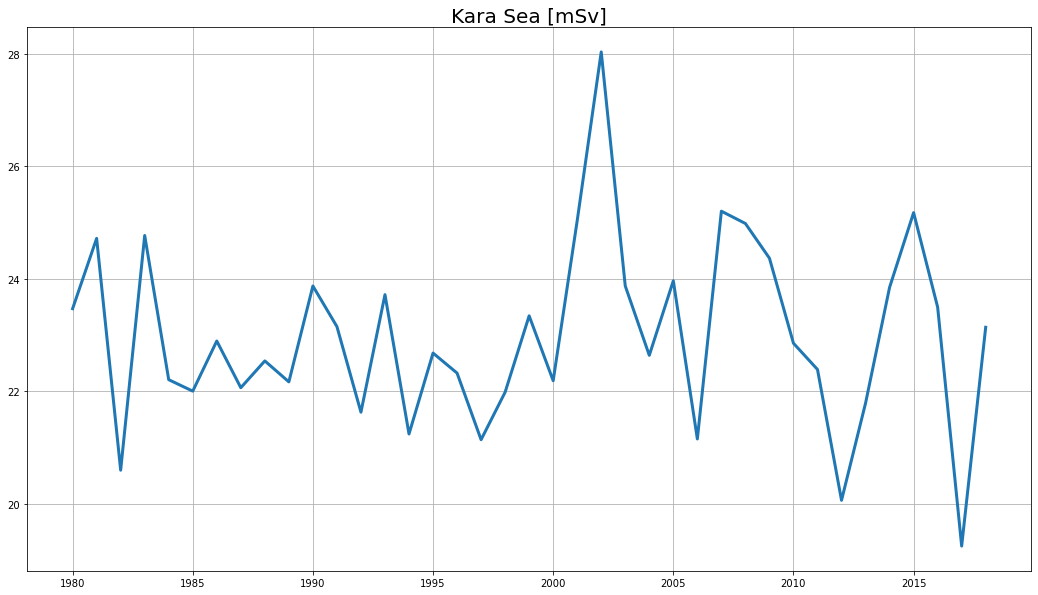

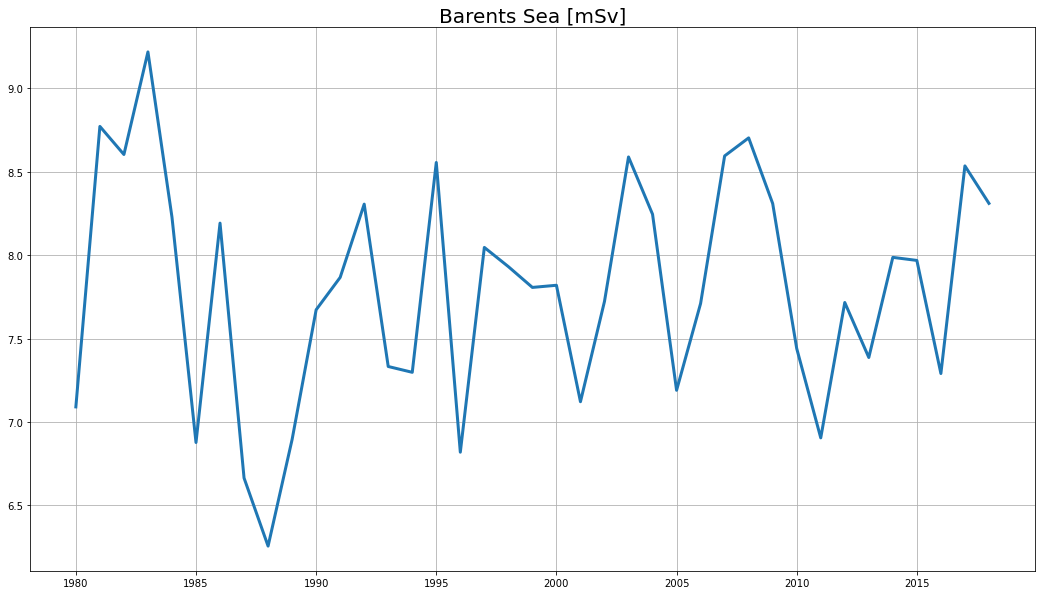

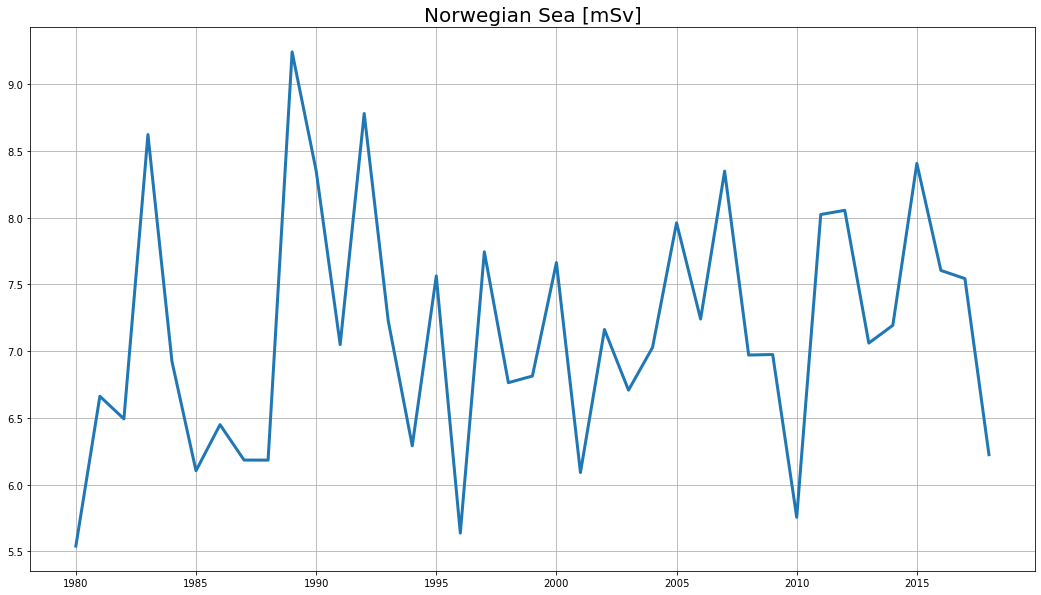

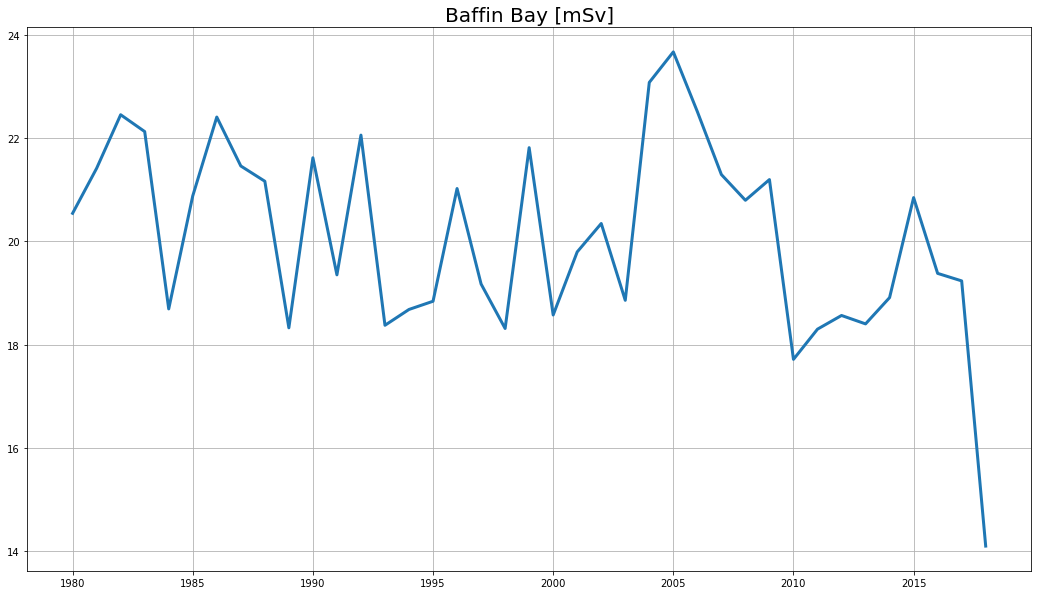

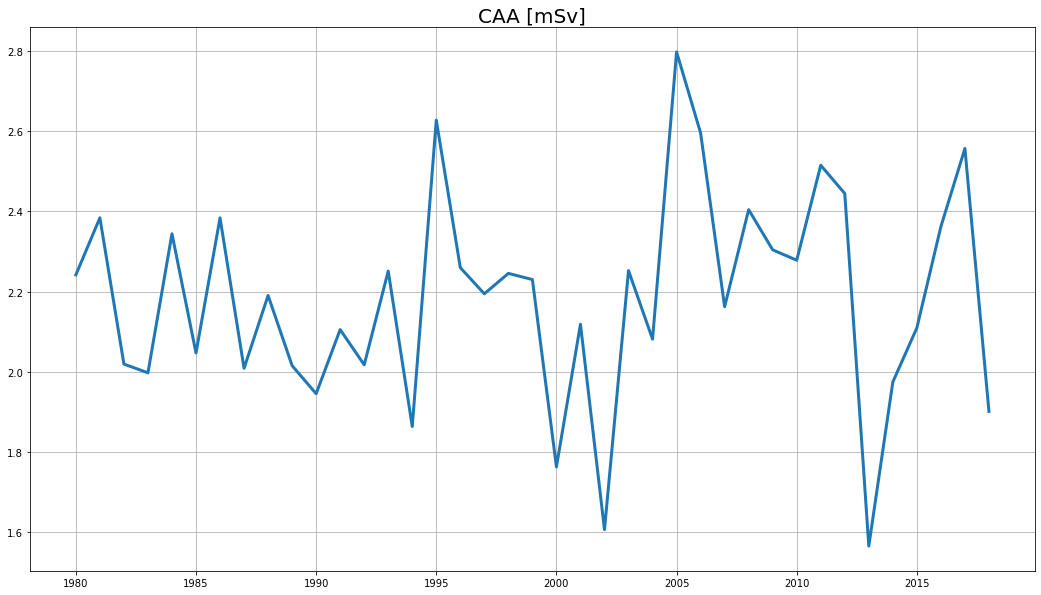

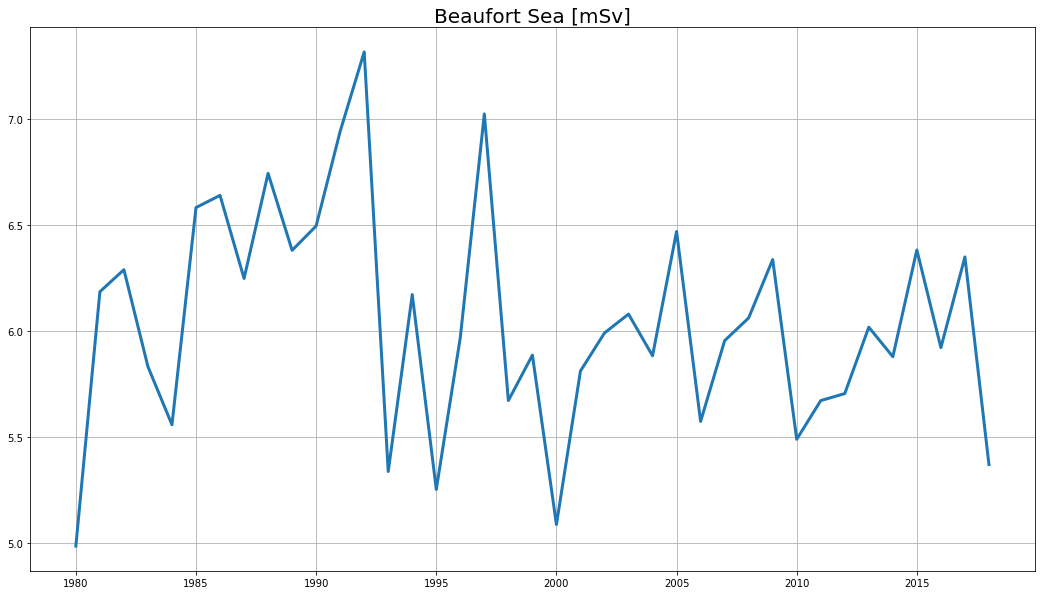

In [40]:
plotdataGAInomean = plotdataGAI - plotdataGAI.mean()
namo=0
for name in ["Chukchi Sea",
    "East Siberian Sea",
    "Laptev Sea",
    "Kara Sea",
    "Barents Sea",
    "Norwegian Sea",
    "Baffin Bay",
    "CAA",
    "Beaufort Sea"]:
    fig = plt.figure(figsize=(18,10),linewidth=2)

    plt.plot(plotdataGAI[name],linewidth=3)
    plt.grid()
    plt.title(name + " [mSv]", fontsize=20)
    plt.savefig(diro+str(namo)+"rivers_flow.png", facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
    namo+=1

In [6]:
rnf_tot_GAI = rnf_perbasin_GAI.chukchi + rnf_perbasin_GAI.eastsiberian + rnf_perbasin_GAI.laptev + rnf_perbasin_GAI.kara + rnf_perbasin_GAI.barents.data + rnf_perbasin_GAI.norwegian \
            + rnf_perbasin_GAI.caa + rnf_perbasin_GAI.beaufort + rnf_perbasin_GAI.baffinHudson 

In [7]:
rnf_russian = rnf_perbasin_GAI.eastsiberian + rnf_perbasin_GAI.laptev + rnf_perbasin_GAI.kara + rnf_perbasin_GAI.barents.data
rnf_n_am = rnf_perbasin_GAI.chukchi + rnf_perbasin_GAI.beaufort + rnf_perbasin_GAI.caa 


In [19]:
rnf_perbasin_GAI.norwegian.mean()/rnf_tot_GAI.mean() * 100
50.5+16.4+24.4+8.7

100.00000000000001

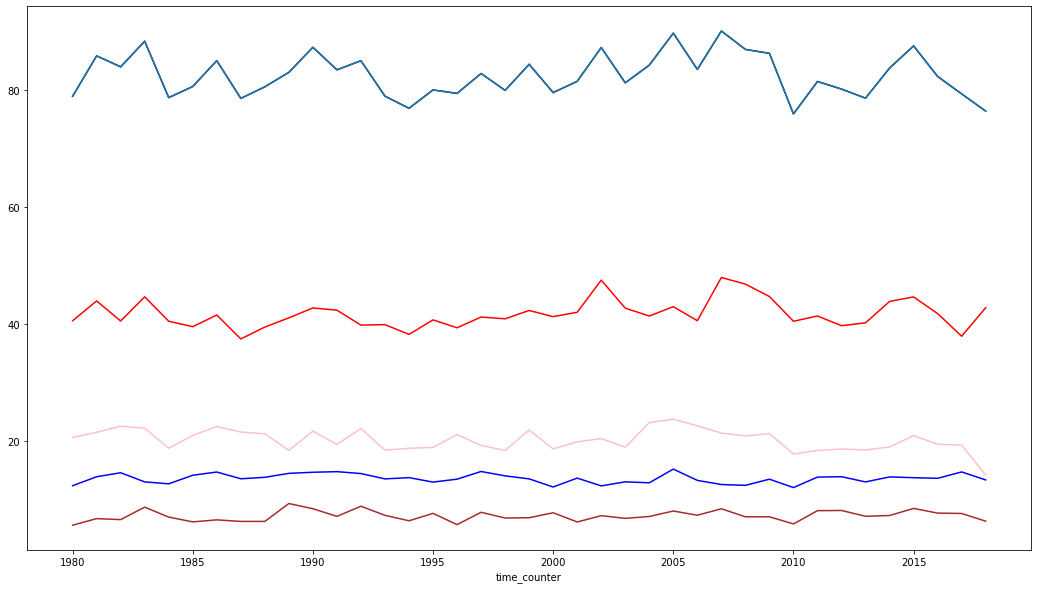

In [12]:
fig = plt.figure(figsize=(18,10),linewidth=2)
rnf_tot_GAI.plot(color='k')
rnf_russian.plot(color='r')
rnf_n_am.plot(color='b')
rnf_perbasin_GAI.baffinHudson.plot(color='pink')
rnf_perbasin_GAI.norwegian.plot(color='brown')


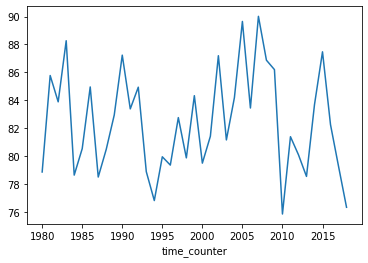

In [38]:
rnf_perbasin_GAI.std().values
rnf_tot_GAI.std().values
rnf_tot_GAI.plot()


In [32]:
rnf_tot_GAI4trend = rnf_tot_GAI.sel(time_counter=slice(1990,2018))


fitcoefftot  = rnf_tot_GAI4trend.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurvetot = fitcoefftot[0].values*rnf_tot_GAI4trend.time_counter.values + fitcoefftot[1].values
print(round(fitcoefftot[0].values*1e3,2))


36.11


In [16]:
# calculer the trends per region from 1990 to 2018
rnf_perbasin_GAI4trend = rnf_perbasin_GAI.sel(time_counter=slice(1990,2018))


fitcoeffSW  = rnf_perbasin_GAI4trend.chukchi.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveSW = fitcoeffSW[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffSW[1].values

fitcoeffCW  = rnf_perbasin_GAI4trend.eastsiberian.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveCW = fitcoeffCW[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffCW[1].values

fitcoeffNW  = rnf_perbasin_GAI4trend.laptev.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveNW = fitcoeffNW[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffNW[1].values

fitcoeffN  = rnf_perbasin_GAI4trend.kara.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveN = fitcoeffN[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffN[1].values

fitcoeffNE  = rnf_perbasin_GAI4trend.barents.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveNE = fitcoeffNE[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffNE[1].values

fitcoeffCE  = rnf_perbasin_GAI4trend.norwegian.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveCE = fitcoeffCE[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffCE[1].values

fitcoeffSE  = rnf_perbasin_GAI4trend.baffinHudson.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurveSE = fitcoeffSE[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffSE[1].values

fitcoeffcaa  = rnf_perbasin_GAI4trend.caa.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurvecaa = fitcoeffcaa[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffcaa[1].values

fitcoeffbeaufort  = rnf_perbasin_GAI4trend.beaufort.polyfit(dim='time_counter', deg=1).polyfit_coefficients
trcurvebeaufort = fitcoeffbeaufort[0].values*rnf_perbasin_GAI4trend.time_counter.values + fitcoeffbeaufort[1].values

print(round(fitcoeffSW[0].values*1e3,2))
print(round(fitcoeffCW[0].values*1e3,2))
print(round(fitcoeffNW[0].values*1e3,2))
print(round(fitcoeffN[0].values*1e3,2))
print(round(fitcoeffNE[0].values*1e3,2))
print(round(fitcoeffCE[0].values*1e3,2))
print(round(fitcoeffSE[0].values*1e3,2))
print(round(fitcoeffcaa[0].values*1e3,2))
print(round(fitcoeffbeaufort[0].values*1e3,2))

-7.95
34.54
15.63
-2.71
6.94
0.73
-60.73
4.38
-15.44


In [20]:
CB_colors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 


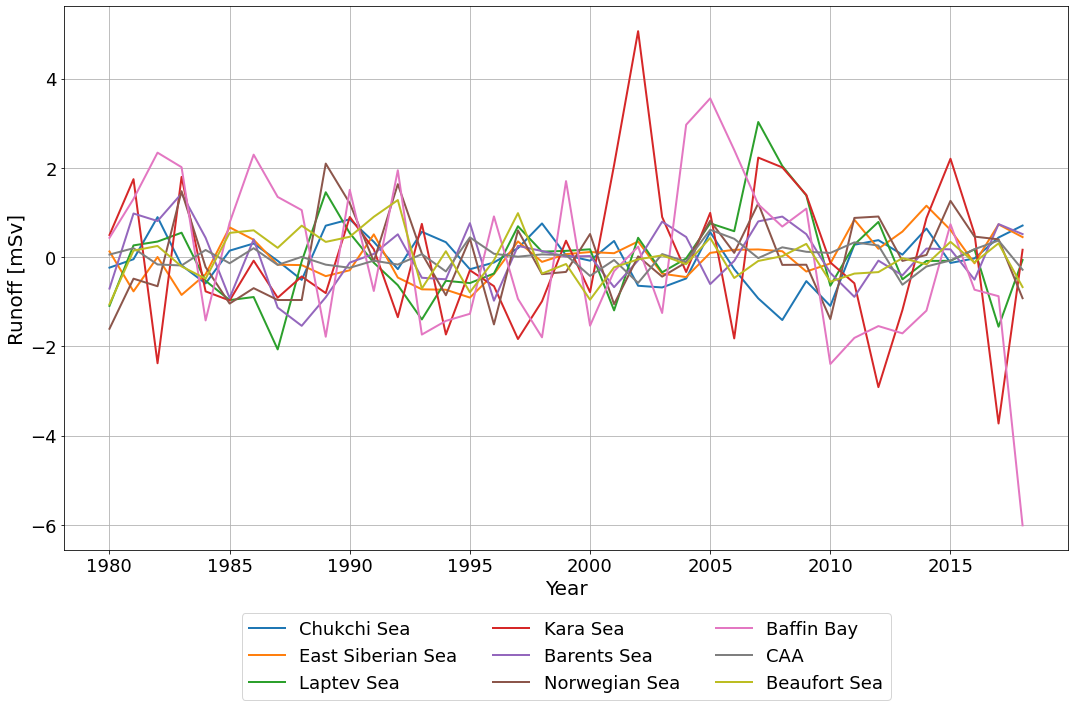

In [23]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

fig = plotdataGAInomean.plot(figsize=(18,10),linewidth=2)



plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Year",fontsize = 20)
plt.ylabel("Runoff [mSv]",fontsize = 20)

plt.grid()
plt.legend(loc='upper center',ncol=3, bbox_to_anchor=(0.5, -0.1), fancybox=True, fontsize=18)

plt.savefig(diro+"rivers_mean_runoff_basinGAIlines.png", facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


# ax1.tick_params(labelsize=14); ax2.tick_params(labelsize=14); ax1.set_xticklabels((np.arange(1980,2019)))


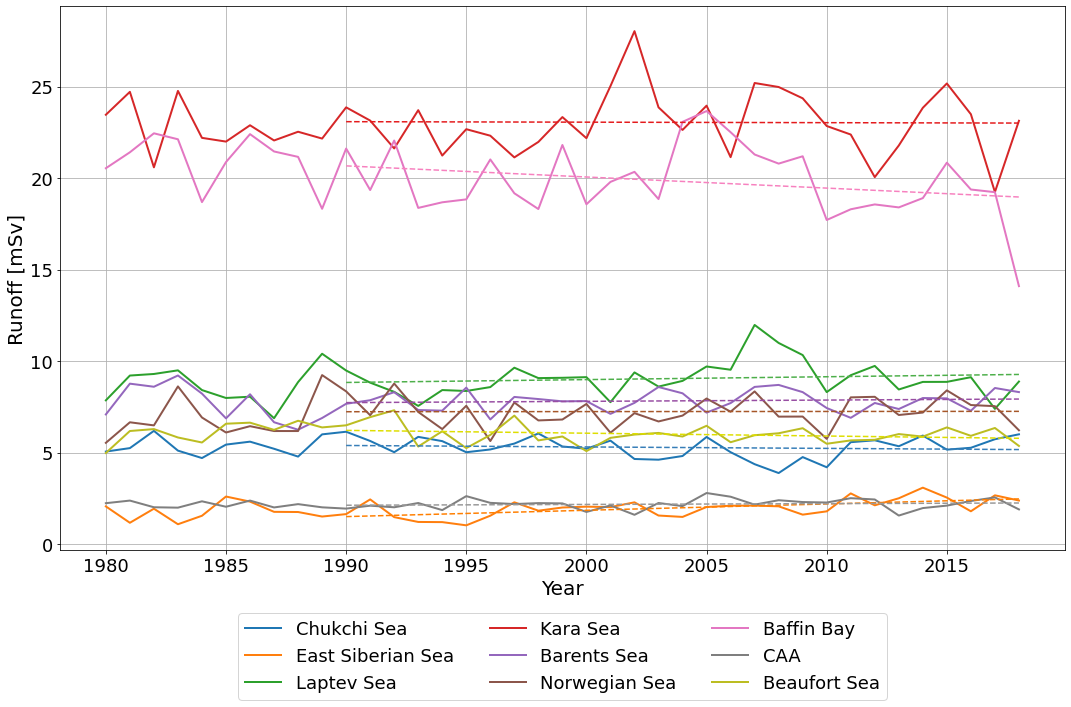

In [20]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

fig = plotdataGAI.plot(figsize=(18,10),linewidth=2)

plt.plot(np.arange(1990,2019),trcurveSW,CB_colors['blue'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurveCW,CB_colors['orange'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurveNW,CB_colors['green'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurveN,CB_colors['red'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurveNE,CB_colors['purple'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurveCE,CB_colors['brown'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurveSE,CB_colors['pink'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurvecaa,CB_colors['gray'],linestyle='dashed')
plt.plot(np.arange(1990,2019),trcurvebeaufort,CB_colors['yellow'],linestyle='dashed')


plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Year",fontsize = 20)
plt.ylabel("Runoff [mSv]",fontsize = 20)

plt.grid()
plt.legend(loc='upper center',ncol=3, bbox_to_anchor=(0.5, -0.1), fancybox=True, fontsize=18)

plt.savefig(diro+"rivers_mean_runoff_basinGAIlines.png", facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


# ax1.tick_params(labelsize=14); ax2.tick_params(labelsize=14); ax1.set_xticklabels((np.arange(1980,2019)))


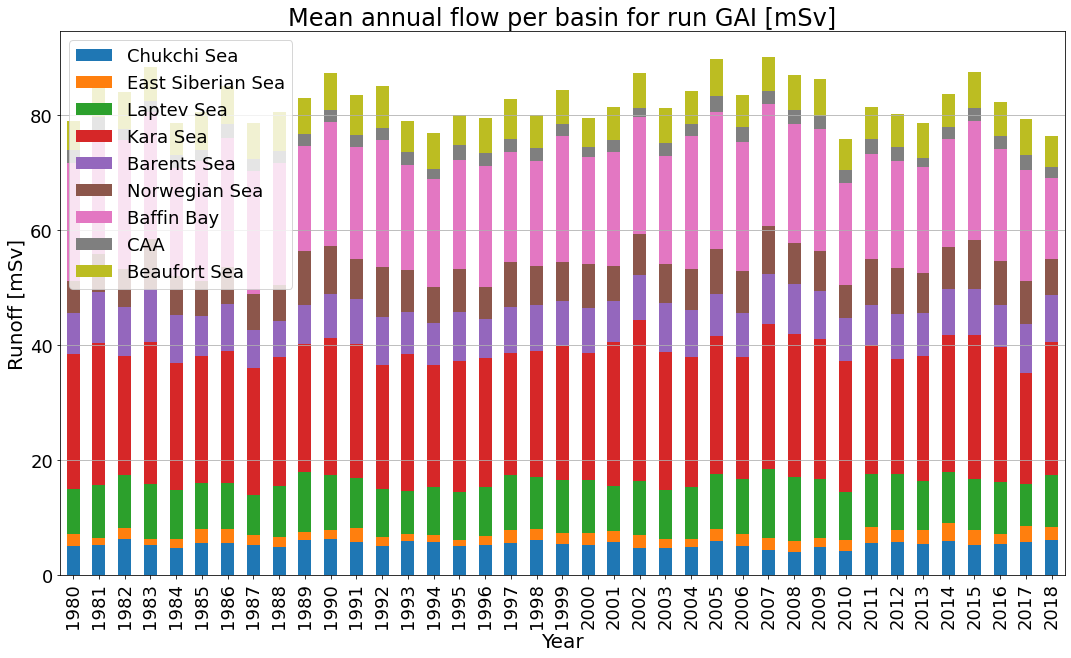

In [21]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
plotdataGAI.plot(kind='bar', stacked=True,figsize=(18,10)) #,facecolor='none')
plt.legend(fontsize=18)
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.xlabel("Year",fontsize = 20) ;plt.ylabel("Runoff [mSv]",fontsize = 20)
plt.grid(axis='y')
plt.title("Mean annual flow per basin for run GAI [mSv]", fontsize = 24)
plt.savefig(diro+"rivers_mean_runoff_basinGAI.png", facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


# Grennland for AI : climatologic

## isolating the rivers of interest: Artic Rivers and saving them !

In [22]:
%%time
path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I"
chunk_size = {"x":360,"y":500} # {"x":500,"y":500} 
rnf = xr.open_dataset(path+"/eORCA025_runoff_ISBA_noAA_noGR_clim_366.nc", chunks=chunk_size).sorunoff

CPU times: user 17 ms, sys: 5.11 ms, total: 22.1 ms
Wall time: 135 ms


In [26]:
%%time
rnf_chukchi = rnf.where(Chukchi_mask,drop=True)
cellArea = cellAreav0.where(Chukchi_mask,drop=True)
debit_chukchi = (rnf_chukchi * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_chukchi = (debit_chukchi/1e3).compute()

rnf_eastsiberian = rnf.where(eastsiberian_mask,drop=True)
cellArea = cellAreav0.where(eastsiberian_mask,drop=True)
debit_eastsiberian = (rnf_eastsiberian * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_eastsiberian = (debit_eastsiberian/1e3).compute()

rnf_laptev = rnf.where(laptev_mask,drop=True)
cellArea = cellAreav0.where(laptev_mask,drop=True)
debit_laptev = (rnf_laptev * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_laptev = (debit_laptev/1e3).compute()

rnf_kara = rnf.where(kara_mask,drop=True)
cellArea = cellAreav0.where(kara_mask,drop=True)
debit_kara = (rnf_kara * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_kara = (debit_kara/1e3).compute()

rnf_barents = rnf.where(barents_mask,drop=True)
cellArea = cellAreav0.where(barents_mask,drop=True)
debit_barents = (rnf_barents * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_barents = (debit_barents/1e3).compute()

rnf_norwegian = rnf.where(norwegian_mask,drop=True)
cellArea = cellAreav0.where(norwegian_mask,drop=True)
debit_norwegian = (rnf_norwegian * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_norwegian = (debit_norwegian/1e3).compute()

rnf_BaffinHudson = rnf.where(BaffinHudson_mask,drop=True)
cellArea = cellAreav0.where(BaffinHudson_mask,drop=True)
debit_BaffinHudson = (rnf_BaffinHudson * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_BaffinHudson = (debit_BaffinHudson/1e3).compute()

rnf_caa = rnf.where(caa_mask,drop=True)
cellArea = cellAreav0.where(caa_mask,drop=True)
debit_caa = (rnf_caa * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_caa = (debit_caa/1e3).compute()

rnf_beaufort = rnf.where(beaufort_mask,drop=True)
cellArea = cellAreav0.where(beaufort_mask,drop=True)
debit_beaufort = (rnf_beaufort * cellArea / 1000).sum(('x','y')).groupby('time_counter.month').mean('time_counter')
debit_beaufort = (debit_beaufort/1e3).compute()

# rnf_tot = rnf.where(tot_mask,drop=True)
# cellArea = cellAreav0.where(tot_mask,drop=True)
# debit_tot = (rnf_tot * cellArea).sum(('x','y'))
# debit_tot = (debit_tot/1e9).compute()

CPU times: user 3.84 s, sys: 261 ms, total: 4.1 s
Wall time: 18.8 s


In [34]:
diroww = '/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/'
ds = xr.Dataset(
    data_vars=dict(chukchi=(["time_counter"], debit_chukchi.data),
                   eastsiberian=(["time_counter"], debit_eastsiberian.data),
                   laptev=(["time_counter"], debit_laptev.data),
                   kara=(["time_counter"], debit_kara.data),
                   barents=(["time_counter"], debit_barents.data),
                   norwegian=(["time_counter"], debit_norwegian.data),
                   baffinHudson=(["time_counter"], debit_BaffinHudson.data),
                   caa=(["time_counter"], debit_caa.data),
                   beaufort=(["time_counter"], debit_beaufort.data),

    ),

    coords=dict(time_counter=np.arange(1,13)),
    attrs=dict(description="mean monthly flow frowrivers dischrage per sea/region for run S [mSv] "),

)

ds.to_netcdf(path=diroww+'rivers_mean_monthly_rnf_perbasin_S.nc')


### vérification

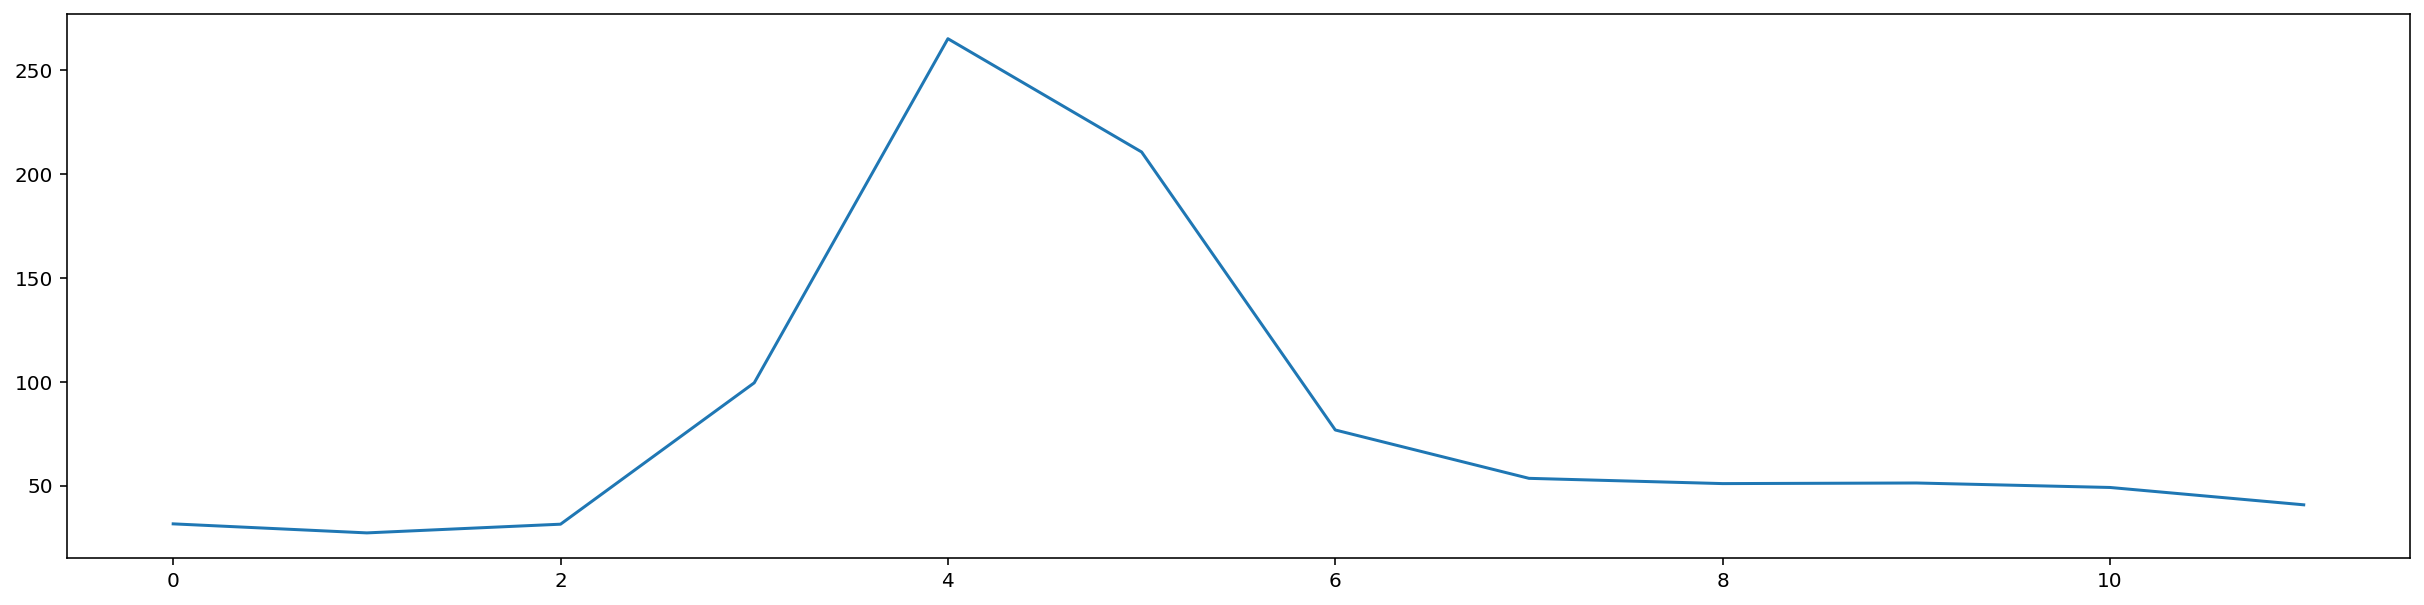

In [35]:
debit_tot = debit_chukchi +debit_eastsiberian +debit_laptev+debit_kara+debit_barents+debit_norwegian+debit_BaffinHudson +debit_caa +debit_beaufort
fig = plt.figure(figsize=([21,5]),facecolor='none', dpi=72*2)
plt.plot(debit_tot.data)

## Load and plot the bar chart

In [39]:
%%time
rnf_perbasin_S = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/rivers_mask/rivers_mean_monthly_rnf_perbasin_S.nc')

plotdataS = pd.DataFrame({
    "Chukchi Sea":rnf_perbasin_S.chukchi.data,
    "East Siberian Sea":rnf_perbasin_S.eastsiberian.data,
    "Laptev Sea":rnf_perbasin_S.laptev.data,
    "Kara Sea":rnf_perbasin_S.kara.data,
    "Barents Sea":rnf_perbasin_S.barents.data,
    "Norwegian Sea":rnf_perbasin_S.norwegian.data,
    "Baffin Bay":rnf_perbasin_S.baffinHudson.data,
    "CAA":rnf_perbasin_S.caa.data,
    "Beaufort Sea":rnf_perbasin_S.beaufort.data},
    index=np.arange(1,13))

CPU times: user 9.31 ms, sys: 2.9 ms, total: 12.2 ms
Wall time: 47.6 ms


In [40]:
totperyearSda = rnf_perbasin_S.chukchi + rnf_perbasin_S.eastsiberian + rnf_perbasin_S.laptev + rnf_perbasin_S.kara + rnf_perbasin_S.barents.data + rnf_perbasin_S.norwegian \
            + rnf_perbasin_S.baffinHudson + rnf_perbasin_S.caa + rnf_perbasin_S.beaufort
totperyearS = np.ones((39))*(totperyearSda.mean('time_counter')).values

In [41]:
pdtotperyearS = pd.DataFrame({
    "totperyearAI":totperyearS},
    index=np.arange(1980,2019))

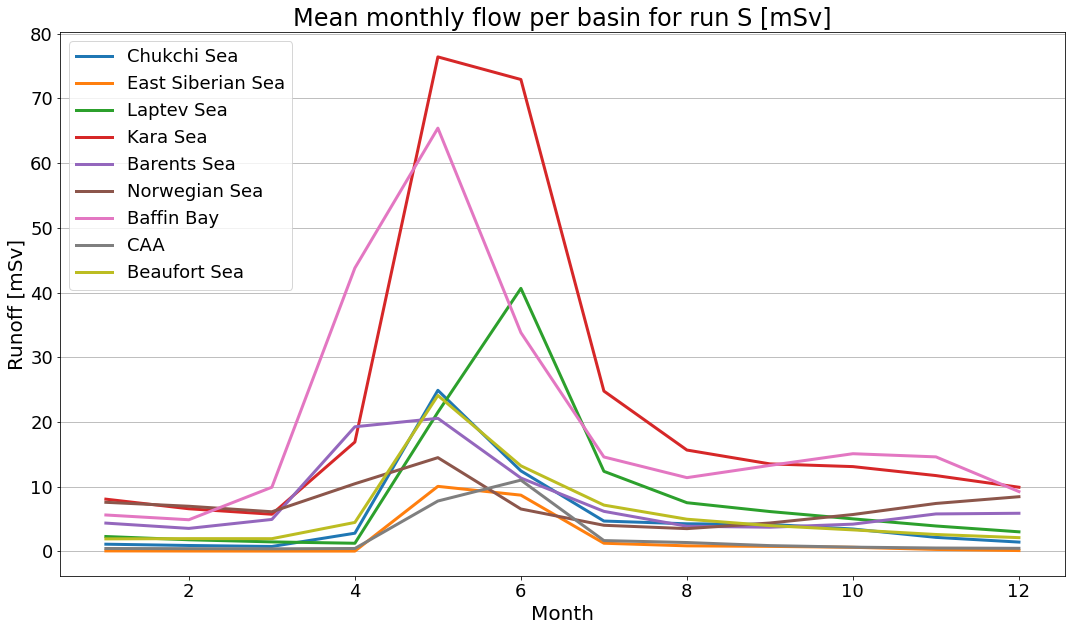

In [43]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
plotdataS.plot(linewidth=3,figsize=(18,10)) #,facecolor='none')
plt.legend(fontsize=18, loc="upper left")
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.xlabel("Month",fontsize = 20) ;plt.ylabel("Runoff [mSv]",fontsize = 20)
plt.title("Mean monthly flow per basin for run S [mSv]", fontsize = 24)
plt.grid(axis='y')


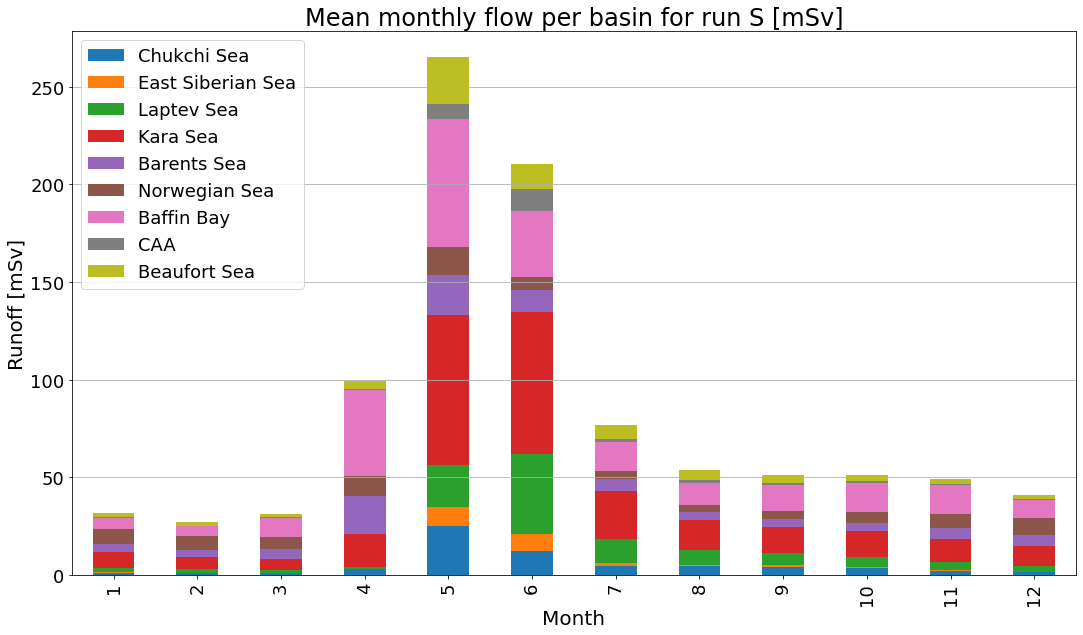

In [38]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
plotdataS.plot(kind='bar', stacked=True,figsize=(18,10)) #,facecolor='none')
plt.legend(fontsize=18, loc="upper left")
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
plt.xlabel("Month",fontsize = 20) ;plt.ylabel("Runoff [mSv]",fontsize = 20)
plt.title("Mean monthly flow per basin for run S [mSv]", fontsize = 24)
plt.grid(axis='y')
plt.savefig(diro+"rivers_mean_monthly_runoff_basinS.png", facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


# plot final figure

In [49]:
CB_colors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

im_true = plt.imread('/gpfswork/rech/cli/uor98hu/MYDATA/Rivers_encartwithcolors.png') # insert local path of the image.

def place_image(im, loc=3, ax=None, zoom=1, **kw):
    if ax==None: ax=plt.gca()
    imagebox = OffsetImage(im, zoom=zoom*0.72)
    ab = AnchoredOffsetbox(loc=loc, child=imagebox, frameon=False, **kw)
    ax.add_artist(ab)

In [51]:


diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
mycolors = [CB_colors['blue'],CB_colors['orange'],CB_colors['green'],CB_colors['red'],CB_colors['purple'],CB_colors['brown'],CB_colors['pink'],CB_colors['gray'],CB_colors['yellow']]

fig,(ax1,ax2) = plt.subplots(1, 2,figsize=(22,9),facecolor='none', dpi=72*2)

# ax1.plot(np.arange(1980,2019),totperyearAI)
# ax = plotdataGAI[["Southwest","Central West","Northwest","North", "Northeast", "Central east","Southeast"]].plot(ax=ax1,kind='bar', stacked=True, color=mycolors, use_index=False)
# plotdataGAI[["totperyearAI"]].plot(ax=ax, color="black",use_index=False)


pdtotperyearS.plot(ax=ax1, kind='line', color='black', use_index=False)
plotdataGAI.plot(ax=ax1,kind='bar', stacked=True,color=mycolors)
plotdataS.plot(ax=ax2,kind='bar', stacked=True,color=mycolors)
ax1.tick_params(labelsize=14); ax2.tick_params(labelsize=14); ax1.set_xticklabels((np.arange(1980,2019)))

ax1.set_xlabel('Year',size=14)
ax2.set_xlabel('Month',size=14)
ax1.set_ylabel("Freshwater discharge [mSv]",fontsize = 14)
ax2.set_ylabel("Freshwater discharge [mSv]",fontsize = 14)
ax1.grid(axis='y')
ax2.grid(axis='y', alpha=0.5)

ax1.legend([])
ax2.legend(loc='upper center',ncol=7, bbox_to_anchor=(-0.1, -0.13), fancybox=True, fontsize=14)


# ax2.legend([])
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
# box = ax2.get_position()
# ax2.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])
# ax1.legend(loc='upper center',ncol=7, bbox_to_anchor=(1.1, -0.15), fancybox=True, fontsize=14)


place_image(im_true, loc=1, ax=ax2, pad=0, zoom=0.35)

# plt.show()
plt.savefig(diro+"Rivers_mean_fw_discharge_GAI_and_S_withencart.png", bbox_inches='tight') #,edgecolor='none',  facecolor=fig.get_facecolor()
plt.close()

array([82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943, 82.3297943,
       82.3297943, 82.3297943, 82.3297943, 82.3297943])